# 1 导入库并查看数据

## 1.1 导入库

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix)
import lightgbm as lgb
import shap
%matplotlib inline

c:\Users\avawa\.conda\envs\ccfd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 确保正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 确保正常显示负号

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

## 1.2 导入并查看数据

In [3]:
data = pd.read_csv('../data/creditcard.csv')
print("数据维度:", data.shape)
data.head()

数据维度: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2 数据预处理

## 2.1 时间特征工程

In [4]:
# 将Time转换为小时和分钟
data['Hour'] = data['Time'] // 3600 % 24
data['Minute'] = (data['Time'] // 60) % 60
# 周期性编码
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

In [5]:
# 时间段分类
time_periods = [0, 6, 12, 18, 24]
period_labels = ['深夜', '上午', '下午', '晚上']
data['TimePeriod'] = pd.cut(data['Hour'], bins=time_periods, labels=period_labels, right=False)

# 交易间隔特征
data = data.sort_values('Time')
data['TimeDelta'] = data['Time'].diff().fillna(0)

print("创建的时间特征:")
print(data[['Hour', 'Minute', 'TimePeriod', 'TimeDelta', 'Hour_sin', 'Hour_cos']].head())

创建的时间特征:
   Hour  Minute TimePeriod  TimeDelta  Hour_sin  Hour_cos
0   0.0     0.0         深夜        0.0       0.0       1.0
1   0.0     0.0         深夜        0.0       0.0       1.0
2   0.0     0.0         深夜        1.0       0.0       1.0
3   0.0     0.0         深夜        0.0       0.0       1.0
4   0.0     0.0         深夜        1.0       0.0       1.0


## 2.2 检查数据分布

### 2.2.1 直方图

C:\Users\avawa\AppData\Local\Temp\ipykernel_27720\2842710257.py:21: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整子图间距
C:\Users\avawa\AppData\Local\Temp\ipykernel_27720\2842710257.py:21: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整子图间距
C:\Users\avawa\AppData\Local\Temp\ipykernel_27720\2842710257.py:21: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整子图间距
C:\Users\avawa\AppData\Local\Temp\ipykernel_27720\2842710257.py:21: UserWarning: Glyph 21320 (\N{CJK UNIFIED IDEOGRAPH-5348}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整子图间距
C:\Users\avawa\AppData\Local\Temp\ipykernel_27720\2842710257.py:21: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # 自动调整子图间距
C:\Users\avawa\AppData\Local\Temp\i

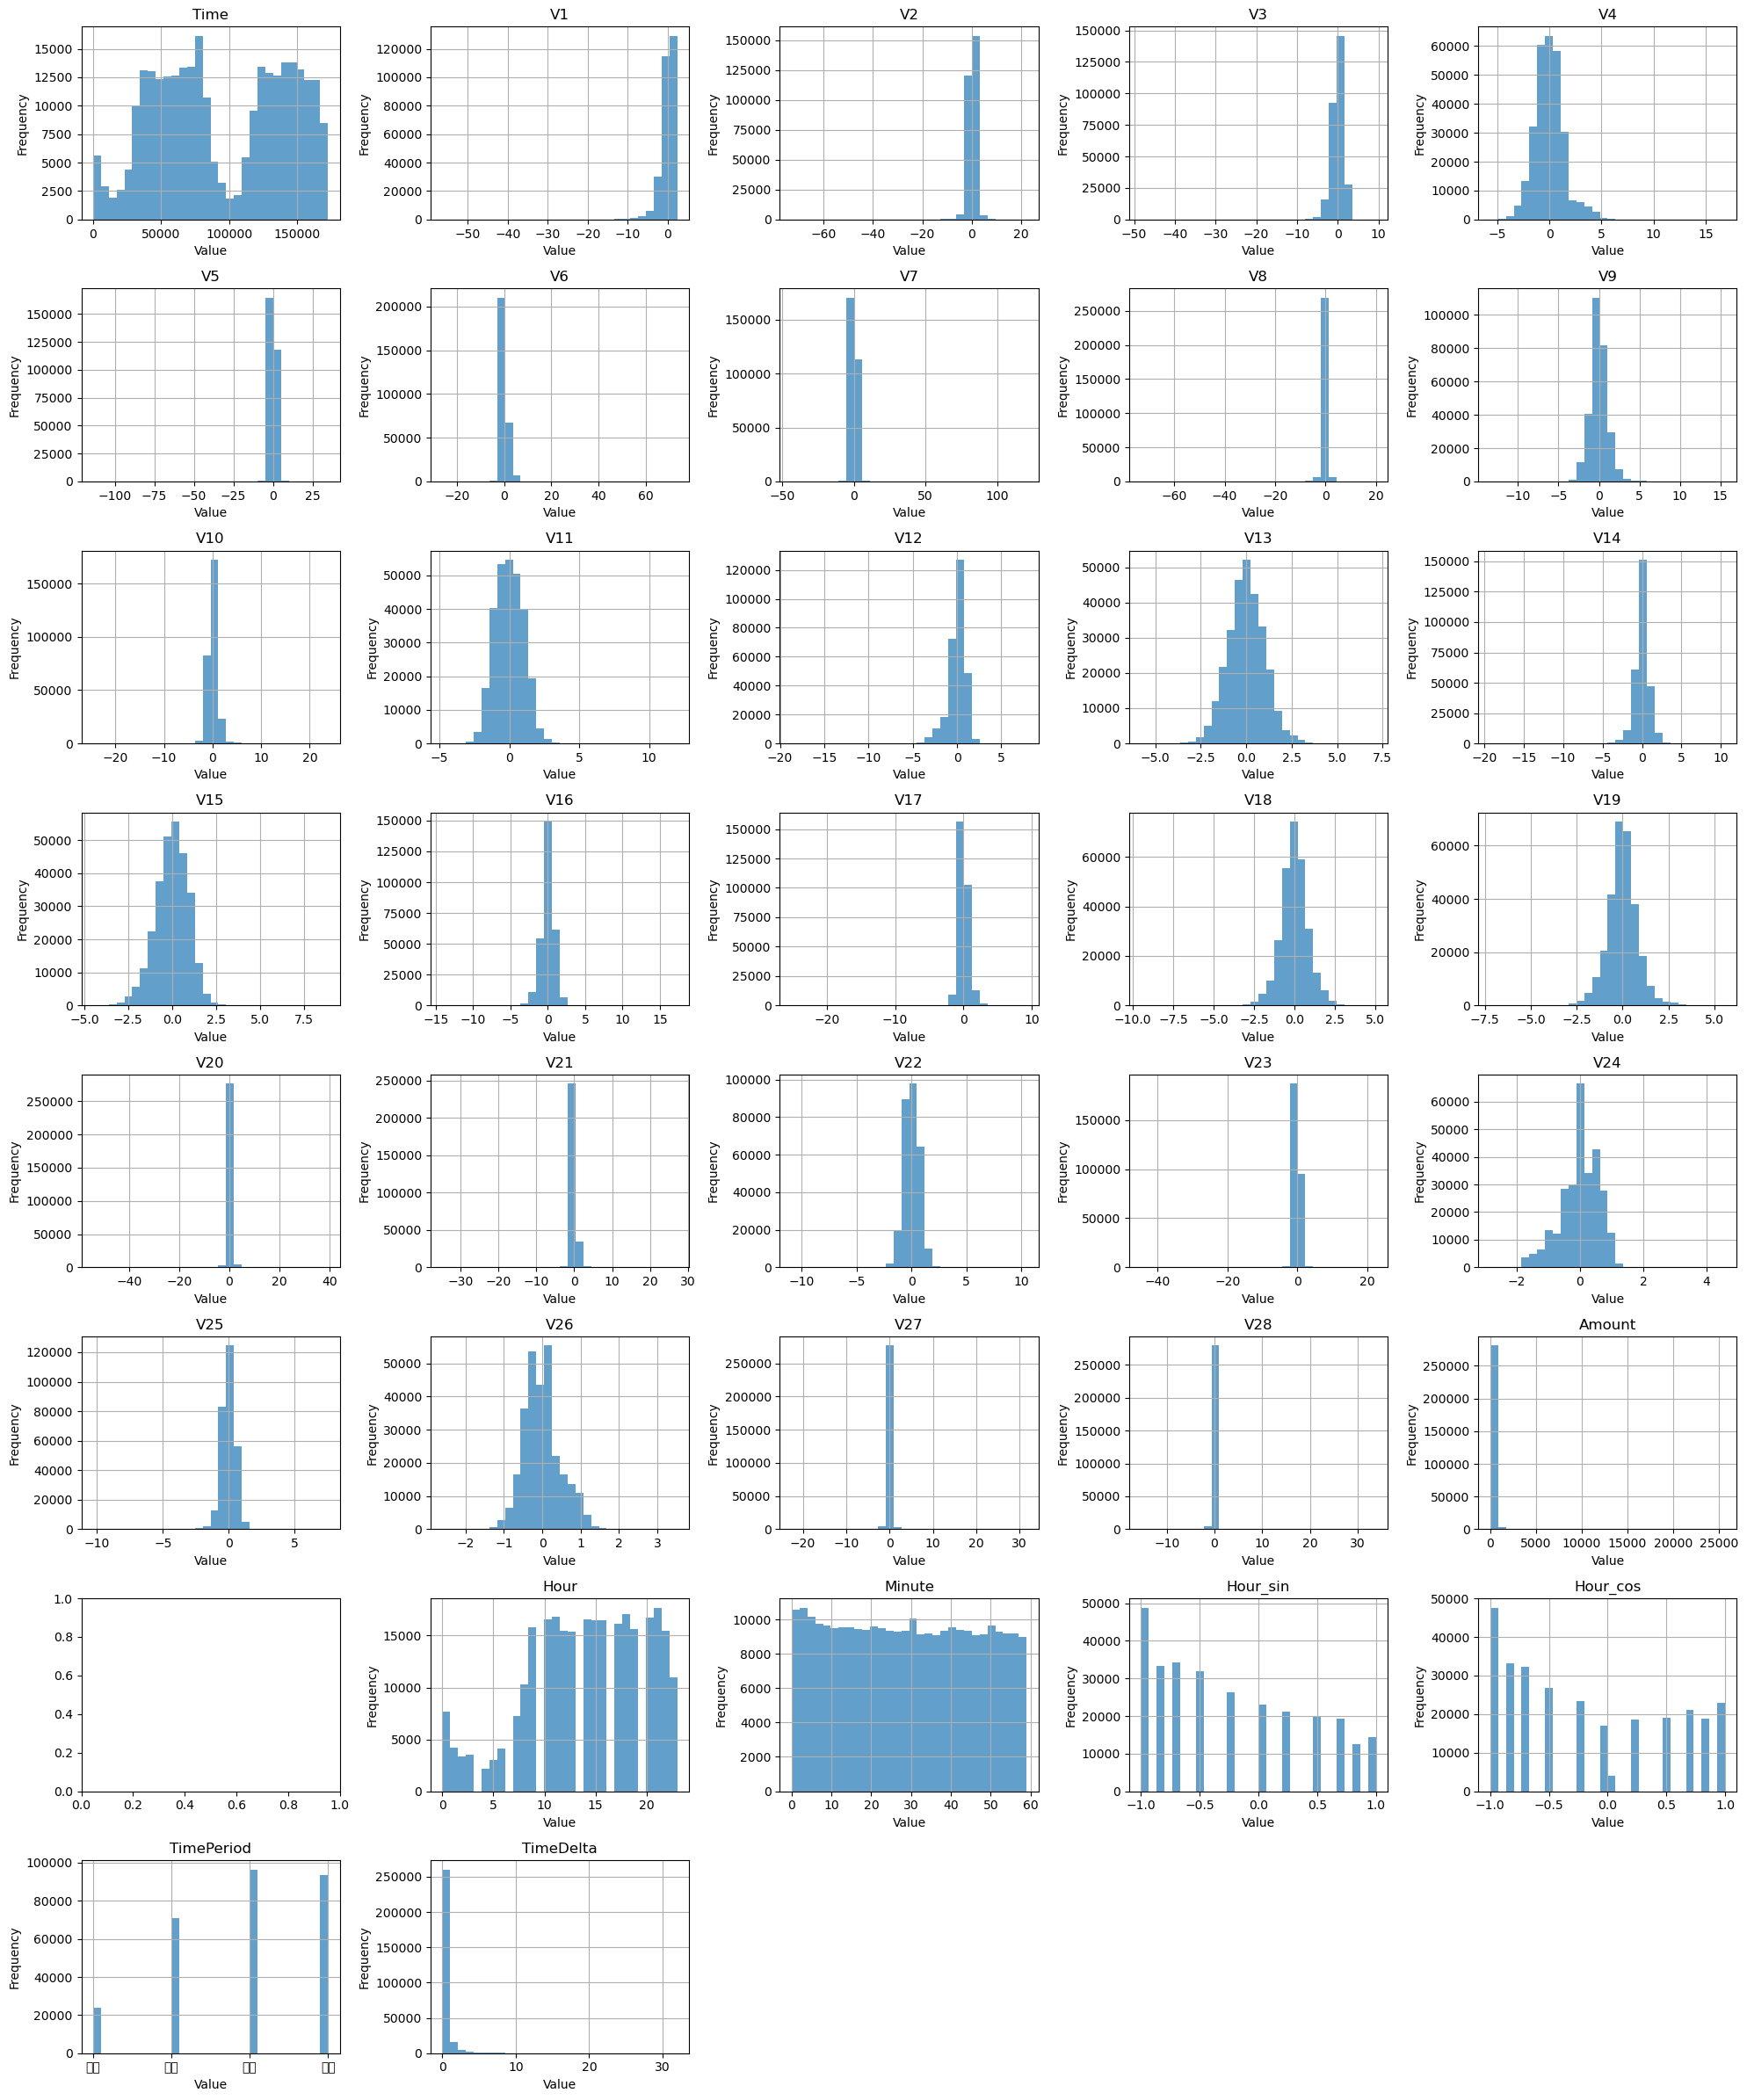

In [6]:
# 设置图形大小
num_features = len(data.columns)  # 特征数量
cols = 5  # 每行显示的图表数量
rows = (num_features + cols - 1) // cols  # 计算行数

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))  # 设置子图网格
axes = axes.flatten()  # 将子图对象展平，方便迭代

for i, column in enumerate(data.columns):
    if column != 'Class':  # 排除目标变量
        ax = axes[i]
        data[column].hist(bins=30, alpha=0.7, ax=ax)  # 绘制直方图
        ax.set_title(column)  # 设置标题
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

# 如果子图数量多于特征数量，隐藏多余的子图
for i in range(len(data.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()  # 自动调整子图间距
plt.show()

### 2.2.2 密度图

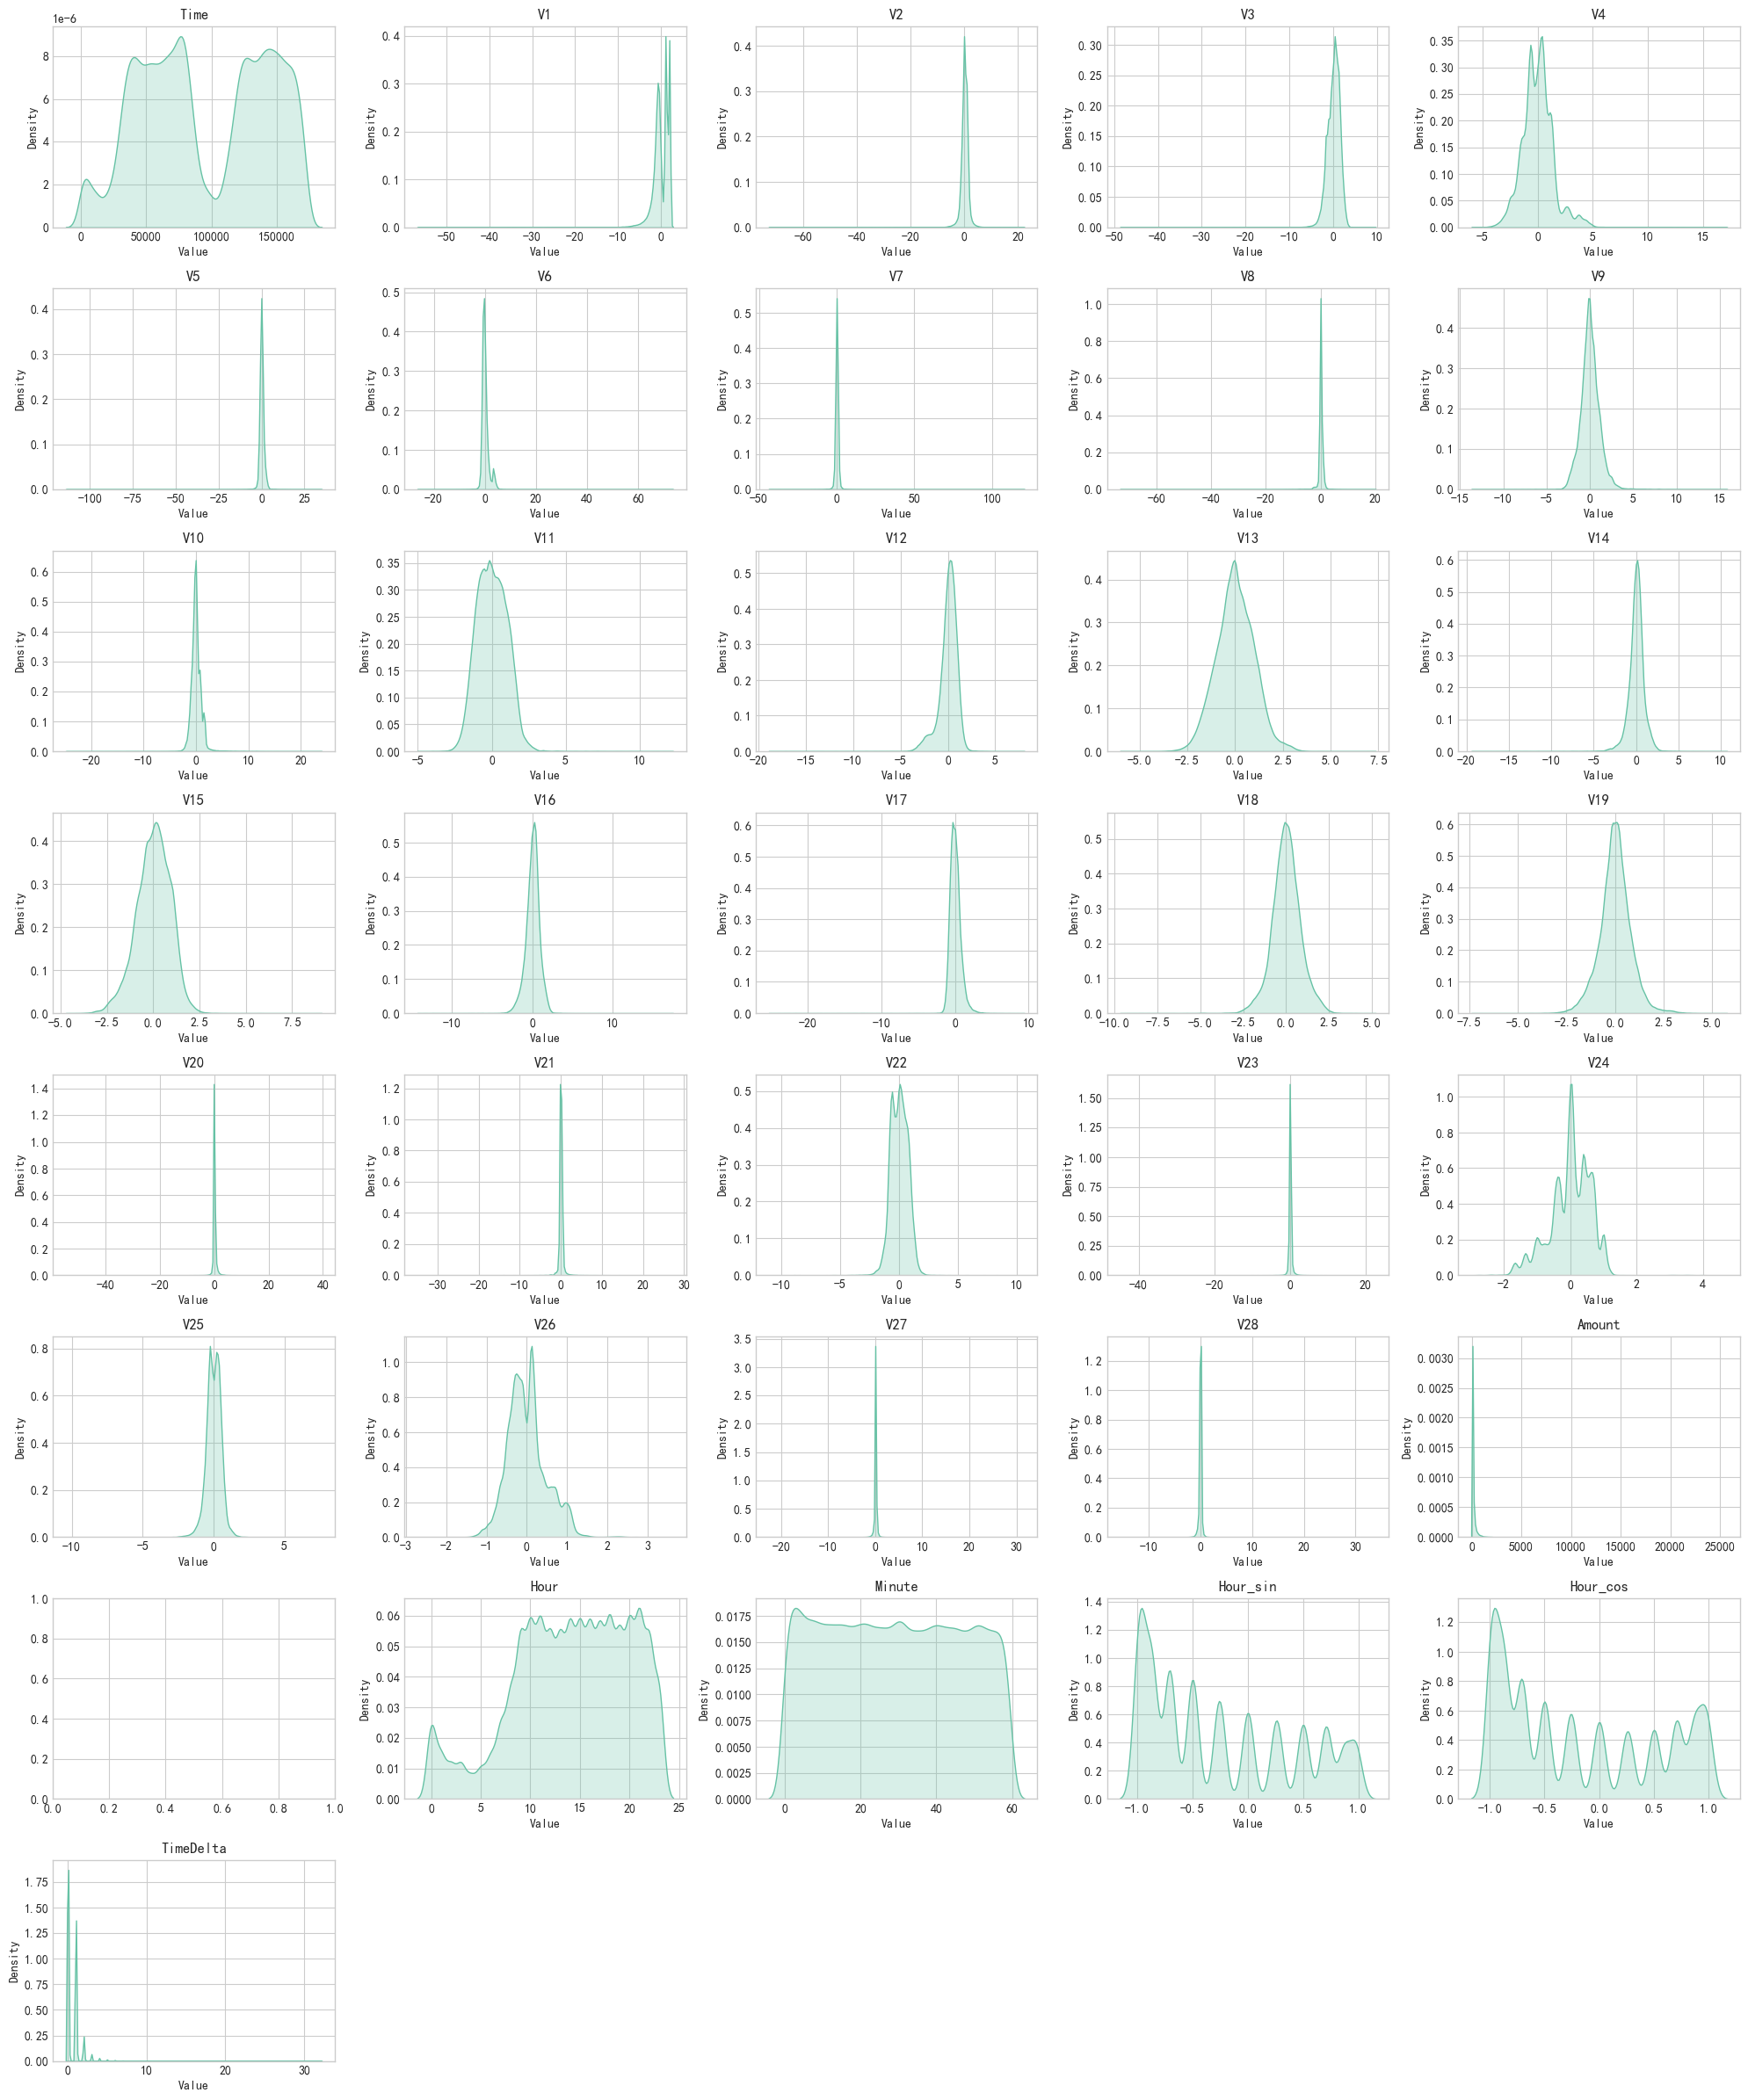

In [6]:
# 设置图形大小
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_features = len(numeric_columns)  # 特征数量
cols = 5  # 每行显示的图表数量
rows = (num_features + cols - 1) // cols  # 计算行数

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))  # 设置子图网格
axes = axes.flatten()  # 将子图对象展平以便于迭代

for i, column in enumerate(numeric_columns):
    if column != 'Class':  # 排除目标变量
        ax = axes[i]
        sns.kdeplot(data[column], ax=ax, shade=True)  # 绘制密度图
        ax.set_title(column)  # 设置标题
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

# 如果子图数量多于特征数量，隐藏多余的子图
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()  # 自动调整子图间距
plt.show()

# 3 数据可视化

## 3.1 欺诈交易时间模式分析

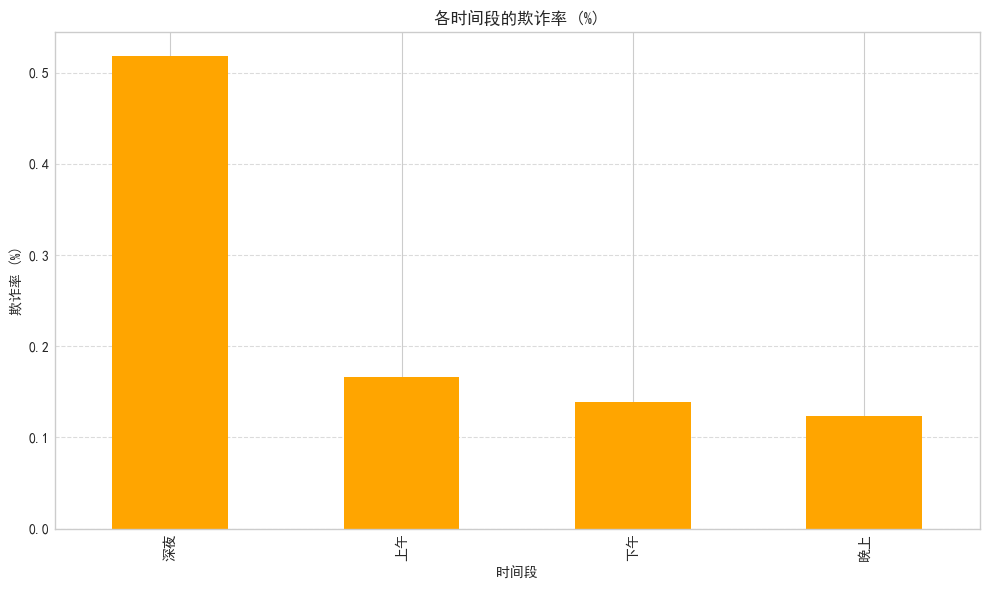

In [7]:
# 时间段与欺诈率关系分析
plt.figure(figsize=(10, 6))
fraud_by_period = data.groupby('TimePeriod')['Class'].mean() * 100
fraud_by_period.plot(kind='bar', color='orange')
plt.title('各时间段的欺诈率 (%)')
plt.xlabel('时间段')
plt.ylabel('欺诈率 (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

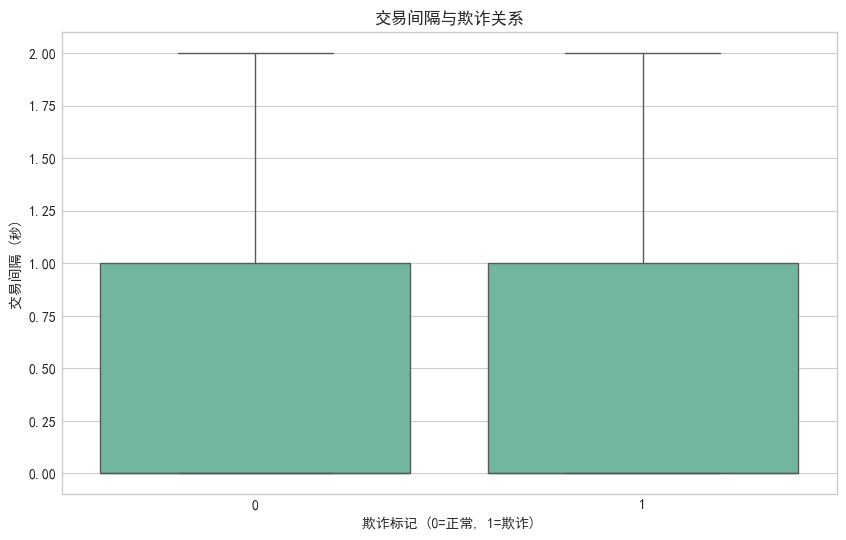

In [8]:
# 交易间隔与欺诈关系
plt.figure(figsize=(10, 6))
# 限制TimeDelta的范围以便更好地可视化
time_delta_max = np.percentile(data['TimeDelta'], 95)  # 95%分位数
time_delta_data = data[data['TimeDelta'] <= time_delta_max]

sns.boxplot(x='Class', y='TimeDelta', data=time_delta_data)
plt.title('交易间隔与欺诈关系')
plt.xlabel('欺诈标记 (0=正常, 1=欺诈)')
plt.ylabel('交易间隔 (秒)')
plt.show()

## 3.2 相关性热图查看特征间关系

Text(0.5, 1.0, '特征与Class的相关性排序')

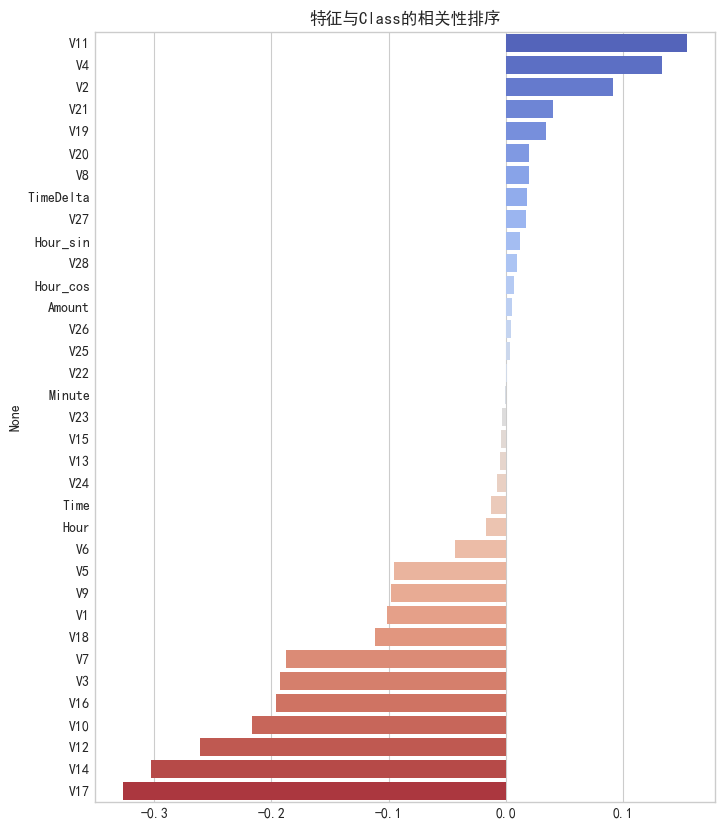

In [11]:
# 排除Class自身
numeric_data = data.select_dtypes(include=['number'])  # 只选择数值型特征
corr_with_class = numeric_data.corr()['Class'].drop('Class').sort_values(ascending=False)  

plt.figure(figsize=(8, 10))
sns.barplot(y=corr_with_class.index, x=corr_with_class.values, palette='coolwarm')
plt.title('特征与Class的相关性排序')

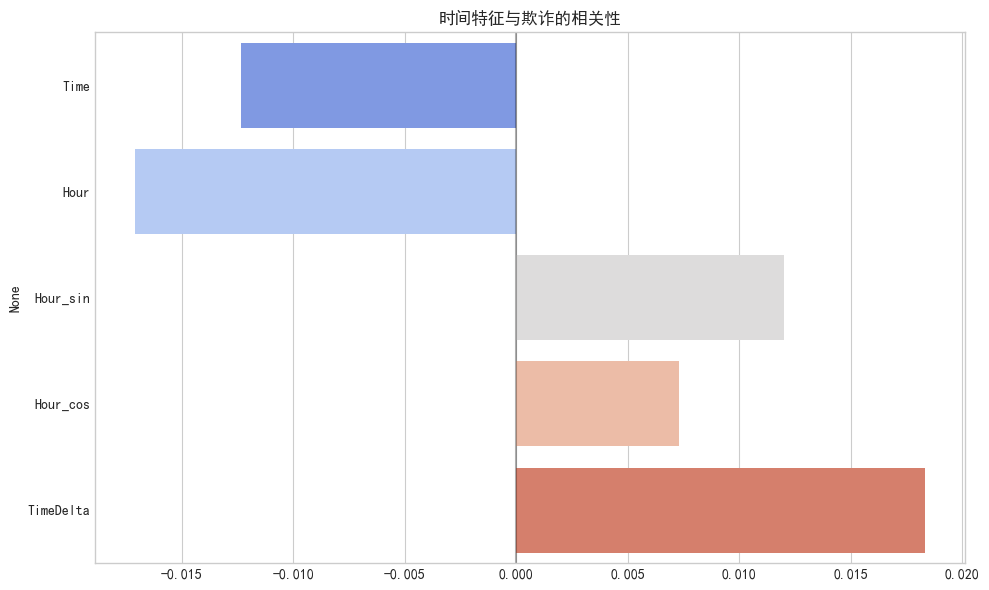

In [12]:
# 时间特征与欺诈的相关性分析
time_features = ['Time', 'Hour', 'Hour_sin', 'Hour_cos', 'DayOfWeek', 
                'IsWeekend', 'TimeDelta']
time_features = [f for f in time_features if f in corr_with_class.index]
time_corr = corr_with_class[time_features]

# 可视化时间特征相关性
plt.figure(figsize=(10, 6))
sns.barplot(y=time_corr.index, x=time_corr.values, palette='coolwarm')
plt.title('时间特征与欺诈的相关性')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# 输出时间特征相关性分析结论
print("\n时间特征与欺诈的相关性排名:")
for feature in time_features:
    corr = round(corr_with_class[feature], 6)
    rank = list(corr_with_class.index).index(feature) + 1
    print(f"- {feature}: 相关性 = {corr}, 总体排名: {rank}/{len(corr_with_class)}")


时间特征与欺诈的相关性排名:
- Time: 相关性 = -0.012323, 总体排名: 22/35
- Hour: 相关性 = -0.017109, 总体排名: 23/35
- Hour_sin: 相关性 = 0.012012, 总体排名: 10/35
- Hour_cos: 相关性 = 0.007313, 总体排名: 12/35
- TimeDelta: 相关性 = 0.018341, 总体排名: 8/35


In [14]:
print("检查Time特征相关性问题:")
print("time_features 内容:", time_features)

if 'time_corr' in locals():
    print("\ntime_corr 内容:")
    print(time_corr)
    
    if 'Time' in time_corr.index:
        time_corr_abs = time_corr.abs()
        print("\nTime相关性绝对值:", time_corr_abs['Time'])
        print("最小相关性绝对值:", time_corr_abs.min())
        print("Time是否有最小相关性:", time_corr_abs['Time'] == time_corr_abs.min())
else:
    print("\ntime_corr变量未定义")

print("\n计算时间特征与欺诈的相关性:")
time_features = ['Time', 'Hour', 'Hour_sin', 'Hour_cos', 'TimeDelta']
time_features = [f for f in time_features if f in data.columns]
print("找到的时间特征:", time_features)

# 计算相关性
time_corr = data[time_features + ['Class']].corr()['Class'].drop('Class')
print("\n相关性计算结果:")
print(time_corr)

# 判断是否值得保留原始Time特征
if 'Time' in time_features:
    time_corr_abs = time_corr.abs()
    print("\n各特征相关性绝对值:")
    print(time_corr_abs)
    
    min_corr_feature = time_corr_abs.idxmin()
    max_corr_feature = time_corr_abs.idxmax()
    
    print(f"\n相关性最低特征: {min_corr_feature} ({time_corr_abs[min_corr_feature]:.6f})")
    print(f"相关性最高特征: {max_corr_feature} ({time_corr_abs[max_corr_feature]:.6f})")
    
    if min_corr_feature == 'Time':
        print("\n结论: 原始Time特征与欺诈的相关性最低，建议在建模时考虑移除")
        print(f"      新创建的时间特征提供了更多信息，尤其是 {max_corr_feature}")
    else:
        print(f"\n结论: {min_corr_feature}特征的相关性最低")
        
        if time_corr_abs['Time'] < 0.05:  # 阈值判断，相关性绝对值小于0.05
            print(f"      但Time特征相关性也很低 ({time_corr_abs['Time']:.6f})，可考虑移除")

检查Time特征相关性问题:
time_features 内容: ['Time', 'Hour', 'Hour_sin', 'Hour_cos', 'TimeDelta']

time_corr 内容:
Time        -0.012323
Hour        -0.017109
Hour_sin     0.012012
Hour_cos     0.007313
TimeDelta    0.018341
Name: Class, dtype: float64

Time相关性绝对值: 0.012322570929245606
最小相关性绝对值: 0.007313475919215699
Time是否有最小相关性: False

计算时间特征与欺诈的相关性:
找到的时间特征: ['Time', 'Hour', 'Hour_sin', 'Hour_cos', 'TimeDelta']

相关性计算结果:
Time        -0.012323
Hour        -0.017109
Hour_sin     0.012012
Hour_cos     0.007313
TimeDelta    0.018341
Name: Class, dtype: float64

各特征相关性绝对值:
Time         0.012323
Hour         0.017109
Hour_sin     0.012012
Hour_cos     0.007313
TimeDelta    0.018341
Name: Class, dtype: float64

相关性最低特征: Hour_cos (0.007313)
相关性最高特征: TimeDelta (0.018341)

结论: Hour_cos特征的相关性最低
      但Time特征相关性也很低 (0.012323)，可考虑移除


# 4 特征工程

## 4.1 特征处理与缩放

In [15]:
# 移除Time
data = data.drop('Time', axis=1)

# 检查并转换分类特征
# 保存分类特征列名
categorical_cols = []
for col in data.columns:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        categorical_cols.append(col)

print(f"检测到的分类特征: {categorical_cols}")

# 对分类特征进行独热编码
if categorical_cols:
    # 保存Class列
    if 'Class' in data.columns:
        y = data['Class'].copy()
        X = data.drop('Class', axis=1)
    else:
        X = data.copy()
        y = None
    
    # 对TimePeriod等分类特征进行独热编码
    if 'TimePeriod' in X.columns:
        print("对TimePeriod特征进行独热编码")
        X = pd.get_dummies(X, columns=['TimePeriod'], prefix='TimePeriod')
    
    # 如果有其他分类特征，也进行编码
    other_cat_cols = [col for col in categorical_cols if col != 'TimePeriod' and col in X.columns]
    if other_cat_cols:
        print(f"对其他分类特征进行独热编码: {other_cat_cols}")
        X = pd.get_dummies(X, columns=other_cat_cols)
    
    # 如果存在, 重新合并Class列
    if y is not None:
        X['Class'] = y
        data = X
    else:
        data = X
else:
    print("未检测到分类特征")

检测到的分类特征: ['TimePeriod']
对TimePeriod特征进行独热编码


In [16]:
# 对 Amount 特征进行标准化
from sklearn.preprocessing import StandardScaler

if 'Amount' in data.columns:
    print("对Amount特征进行标准化")
    scaler = StandardScaler()
    data['Amount'] = scaler.fit_transform(data[['Amount']])

# 分离特征和目标变量
if 'Class' in data.columns:
    X = data.drop('Class', axis=1)
    y = data['Class']
else:
    X = data.copy()
    y = None

对Amount特征进行标准化


## 4.2 时间序列数据分割

In [17]:
X = data.drop('Class', axis=1)
y = data['Class']

# 使用分层抽样确保训练集和测试集有相似的类别分布
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("数据已分割为训练集和测试集")
print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
print("训练集类别分布:")
print(y_train.value_counts(normalize=True))
print("\n测试集类别分布:")
print(y_test.value_counts(normalize=True))

数据已分割为训练集和测试集
训练集形状: (227845, 38), 测试集形状: (56962, 38)
训练集类别分布:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

测试集类别分布:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


## 4.3 特征选择

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

print("执行L1正则化特征选择...")
# 确认Time已被移除
if 'Time' in X_train.columns:
    print("警告: Time特征仍存在，将被移除")
    X_train = X_train.drop('Time', axis=1)
    X_test = X_test.drop('Time', axis=1)

# 使用L1正则化进行特征选择    
selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=0.1),
    threshold='median'
).fit(X_train, y_train)

# 获取所选特征
selected_features = X_train.columns[selector.get_support()].tolist()

# 更新数据集
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"特征选择前: {X_train.shape[1]}个特征")
print(f"特征选择后: {len(selected_features)}个特征")
print(f"最终选择特征：{selected_features}")

# 更新训练集和测试集
X_train = X_train_selected
X_test = X_test_selected
print(f"最终选择特征：{selected_features}")

执行L1正则化特征选择...
特征选择前: 38个特征
特征选择后: 19个特征
最终选择特征：['V4', 'V5', 'V6', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V17', 'V20', 'V21', 'V22', 'V23', 'V27', 'Hour', 'Hour_sin', 'TimeDelta', 'TimePeriod_上午']
最终选择特征：['V4', 'V5', 'V6', 'V8', 'V9', 'V10', 'V13', 'V14', 'V16', 'V17', 'V20', 'V21', 'V22', 'V23', 'V27', 'Hour', 'Hour_sin', 'TimeDelta', 'TimePeriod_上午']


## 4.4 处理不平衡数据

In [22]:
# 查看类别分布
class_counts = data['Class'].value_counts()
print(class_counts)

# 查看比例
class_ratios = data['Class'].value_counts(normalize=True)
print(class_ratios)

Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 后续用 X_train_resampled 和 y_train_resampled 替代原训练集
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)

In [24]:
# 保存训练集和测试集
import joblib
import os

# 创建输出目录（若不存在）
os.makedirs('../outputs/datasets', exist_ok=True)
os.makedirs('../outputs/features', exist_ok=True)

# 保存训练集和测试集
joblib.dump(X_train_resampled, '../outputs/datasets/X_train.pkl')
joblib.dump(X_test, '../outputs/datasets/X_test.pkl')
joblib.dump(y_train_resampled, '../outputs/datasets/y_train.pkl')
joblib.dump(y_test, '../outputs/datasets/y_test.pkl')

# 保存选择的特征列表
joblib.dump(selected_features, '../outputs/features/selected_features.pkl')

print("训练集和测试集已保存到 '../outputs/' 目录")

训练集和测试集已保存到 '../outputs/' 目录


In [26]:
class_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])  # 自动计算权重比

# 5 模型训练与评估

## 5.1 模型训练

### 5.1.1 设置超参数

In [27]:
import lightgbm as lgb

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss', # 评价指标
    'boosting_type': 'dart',  # 更适合时间序列
    
    # 基础参数
    'learning_rate': 0.05, # 学习率
    'num_leaves': 31, # 最大叶子节点数
    'max_depth': 6,    # 树的最大深度，防止过拟合
    
    # 采样参数
    'feature_fraction': 0.8,  # 每次迭代使用的特征比例，防止过拟合
    'bagging_fraction': 0.8,  # 每次迭代使用的数据比例，防止过拟合
    'bagging_freq': 5,  # 每 5 次迭代进行一次 bagging
    
    # 正则化参数
    'lambda_l1': 0.1,  # L1 正则化
    'lambda_l2': 0.2,  # L2 正则化
    
    # 叶子节点参数
    'min_data_in_leaf': 20,  # 每个叶子节点的最小样本数，防止过拟合
    'min_child_weight': 0.02, # 使一个结点分裂的最小海森值之和
    'max_bin': 255,  # 特征分箱的最大数量，较大的值可以提高精度但会增加计算量
    'verbosity': -1,  # 关闭训练过程中的日志输出
    
    # 类别不平衡参数
    'scale_pos_weight': class_weight,  # 已有的类别权重设置
    'focal_loss': True,  # 使用focal loss处理不平衡
    'focal_alpha': 0.25,  # focal loss的alpha参数
    'focal_gamma': 2.0,   # focal loss的gamma参数
    
    # DART 特定参数
    'drop_rate': 0.1,      # 每次迭代丢弃树的比例 (0.0-1.0)
    'skip_drop': 0.5,      # 跳过dropout的概率 (0.0-1.0)
    'max_drop': 50,        # 丢弃树的最大数量，<=0 表示没有限制
    'uniform_drop': False, # True表示均匀丢弃，False表示按权重丢弃
    'xgboost_dart_mode': False, # 是否使用与xgboost dart模式完全兼容的算法
    'drop_seed': 4,        # dropout随机数种子
}

### 5.1.2 定义AUPRC评估函数

In [28]:
from sklearn.metrics import average_precision_score

# 自定义 AUPRC 评估函数
def auprc_eval(preds, train_data):
    labels = train_data.get_label()  # 获取真实标签
    score = average_precision_score(labels, preds)  # 计算 AUPRC
    return 'auprc', score, True  # 返回指标名称、值和是否越高越好

In [29]:
from sklearn.metrics import average_precision_score

def calculate_auprc(model, X_val, y_val):
    """
    计算验证集上的 AUPRC (Average Precision Score)
    """
    # 使用模型预测概率
    y_pred = model.predict(X_val)
    # 计算 AUPRC
    return average_precision_score(y_val, y_pred)

### 5.1.3 训练模型

In [30]:
# 训练模型
from lightgbm import early_stopping
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[early_stopping(stopping_rounds=50)],
        feval=auprc_eval  # 使用自定义 AUPRC 评估函数
    )
    print(f"Fold {fold+1} AUPRC:", calculate_auprc(model, X_val, y_val))

Fold 1 AUPRC: 0.5608595958119938
Fold 2 AUPRC: 0.5321935278154657
Fold 3 AUPRC: 0.6421719589213127
Fold 4 AUPRC: 0.616062927397146
Fold 5 AUPRC: 0.6821256810786223


### 5.1.4 对测试集进行预测

In [31]:
# 使用模型对测试集进行预测
y_pred = model.predict(X_test)

## 5.2 模型评估

### 5.2.1 对预测结果进行评估

In [32]:
from sklearn.metrics import precision_recall_curve, auc

# 计算 Precision-Recall 曲线
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# 计算 AUPRC
auprc = auc(recall, precision)
print("Test AUPRC:", auprc)

Test AUPRC: 0.6186652798666611


### 5.2.2 检查 Precision-Recall曲线

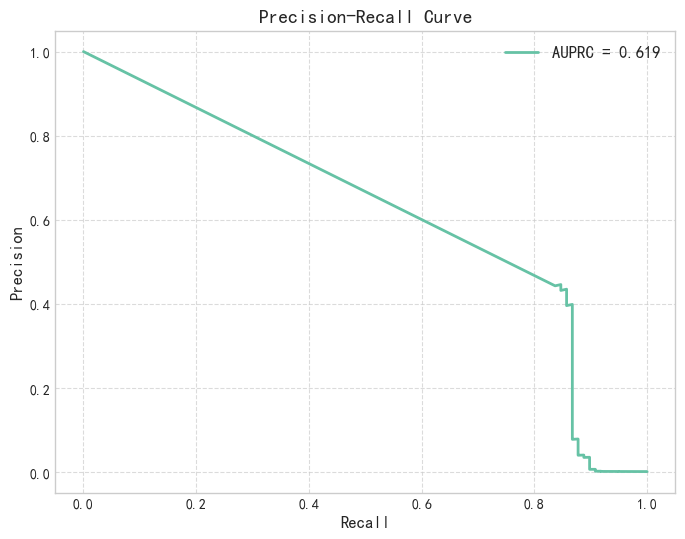

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AUPRC = {auprc:.3f}", linewidth=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 5.3 超参数调优

### 5.3.1 参数空间定义

In [34]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import average_precision_score

# 需要调优的参数
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [4, 6, 8, -1],  # -1表示无限制
    'min_child_weight': [0.01, 0.02, 0.05],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'cat_smooth': [1, 10, 20],
    'cat_l2': [1, 10]
}

print("参数搜索空间:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

参数搜索空间:
  learning_rate: [0.01, 0.05, 0.1]
  num_leaves: [15, 31, 63]
  max_depth: [4, 6, 8, -1]
  min_child_weight: [0.01, 0.02, 0.05]
  min_child_samples: [10, 20, 30]
  subsample: [0.7, 0.8, 0.9]
  colsample_bytree: [0.7, 0.8, 0.9]
  reg_alpha: [0, 0.1, 0.5]
  reg_lambda: [0, 0.1, 0.5]
  cat_smooth: [1, 10, 20]
  cat_l2: [1, 10]


### 5.3.2 交叉验证设置

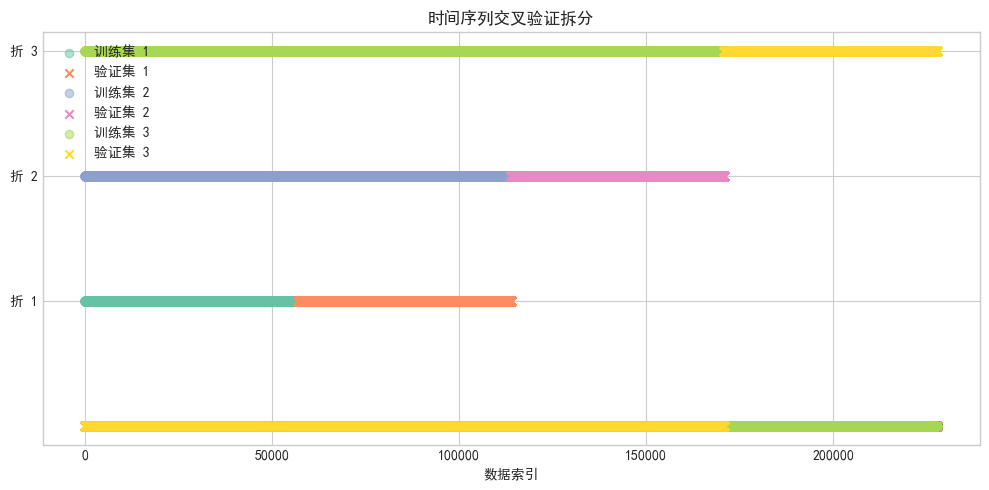

使用AUPRC作为评估指标


In [35]:
# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=3)

# 可视化交叉验证拆分
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    train_mask = np.zeros(len(X_train), dtype=bool)
    val_mask = np.zeros(len(X_train), dtype=bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    
    ax.scatter(range(len(X_train)), train_mask * (i + 1), label=f'训练集 {i+1}', alpha=0.5)
    ax.scatter(range(len(X_train)), val_mask * (i + 1), label=f'验证集 {i+1}', marker='x')

ax.set_title('时间序列交叉验证拆分')
ax.set_xlabel('数据索引')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['折 1', '折 2', '折 3'])
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 配置评估指标
print("使用AUPRC作为评估指标")

### 5.3.3 随机搜索优化

执行20次随机搜索...

迭代 1/20
  折 1 AUPRC: 0.7728
  折 2 AUPRC: 0.7105
  折 3 AUPRC: 0.7425
  平均AUPRC: 0.7419
  发现新的最佳AUPRC: 0.7419

迭代 2/20
  折 1 AUPRC: 0.6726
  折 2 AUPRC: 0.5337
  折 3 AUPRC: 0.5884
  平均AUPRC: 0.5983

迭代 3/20
  折 1 AUPRC: 0.7199
  折 2 AUPRC: 0.7293
  折 3 AUPRC: 0.6864
  平均AUPRC: 0.7119

迭代 4/20
  折 1 AUPRC: 0.7693
  折 2 AUPRC: 0.7482
  折 3 AUPRC: 0.7409
  平均AUPRC: 0.7528
  发现新的最佳AUPRC: 0.7528

迭代 5/20
  折 1 AUPRC: 0.7127
  折 2 AUPRC: 0.7350
  折 3 AUPRC: 0.6053
  平均AUPRC: 0.6843

迭代 6/20
  折 1 AUPRC: 0.0958
  折 2 AUPRC: 0.0613
  折 3 AUPRC: 0.0802
  平均AUPRC: 0.0791

迭代 7/20
  折 1 AUPRC: 0.6732
  折 2 AUPRC: 0.4447
  折 3 AUPRC: 0.6055
  平均AUPRC: 0.5745

迭代 8/20
  折 1 AUPRC: 0.1841
  折 2 AUPRC: 0.1209
  折 3 AUPRC: 0.1050
  平均AUPRC: 0.1367

迭代 9/20
  折 1 AUPRC: 0.7278
  折 2 AUPRC: 0.7697
  折 3 AUPRC: 0.7250
  平均AUPRC: 0.7408

迭代 10/20
  折 1 AUPRC: 0.3111
  折 2 AUPRC: 0.3236
  折 3 AUPRC: 0.1197
  平均AUPRC: 0.2515

迭代 11/20
  折 1 AUPRC: 0.7692
  折 2 AUPRC: 0.7892
  折 3 AUPRC: 0.6453
  

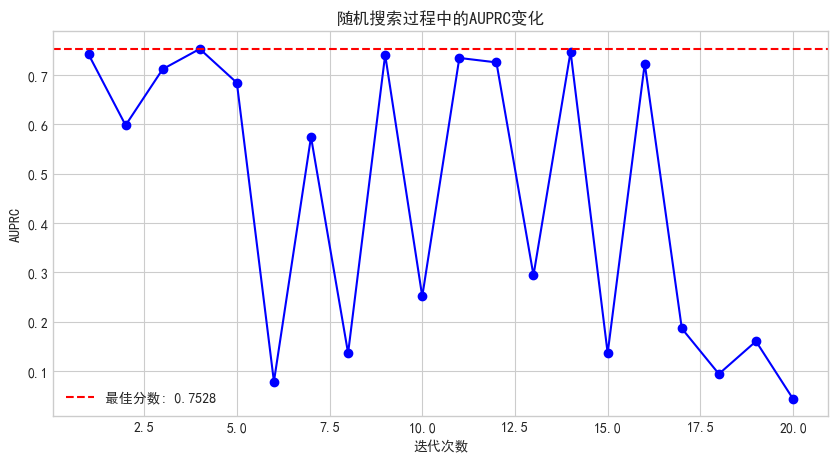


最终最佳AUPRC: 0.7528
最优参数:
  learning_rate: 0.01
  num_leaves: 31
  max_depth: 8
  min_child_weight: 0.02
  min_child_samples: 20
  subsample: 0.8
  colsample_bytree: 0.9
  reg_alpha: 0.0
  reg_lambda: 0.1
  cat_smooth: 1
  cat_l2: 1
  objective: binary
  metric: auc
  boosting_type: dart
  time_series: True
  verbosity: -1
  scale_pos_weight: 577.2868020304569


In [36]:
# 最佳参数和分数初始化
best_params = {}
best_score = 0

# 随机搜索迭代次数
n_iterations = 20
print(f"执行{n_iterations}次随机搜索...")

# 随机搜索历史记录
search_history = []

# 随机搜索
for i in range(n_iterations):
    print(f"\n迭代 {i+1}/{n_iterations}")
    
    # 随机选择参数
    params_sample = {}
    for param, values in param_grid.items():
        params_sample[param] = np.random.choice(values)
    
    # 添加固定参数
    params_sample.update({
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'dart',
        'time_series': True,
        'verbosity': -1,
        'scale_pos_weight': class_weight
    })
    
    # 交叉验证
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 创建训练集
        train = lgb.Dataset(X_tr, label=y_tr)
        
        # 训练模型
        model = lgb.train(
            params_sample,
            train,
            num_boost_round=100
        )
        
        # 预测验证集
        y_pred = model.predict(X_val)
        
        # 计算AUPRC
        auprc = average_precision_score(y_val, y_pred)
        cv_scores.append(auprc)
        print(f"  折 {fold+1} AUPRC: {auprc:.4f}")
    
    # 计算平均AUPRC
    mean_auprc = np.mean(cv_scores)
    print(f"  平均AUPRC: {mean_auprc:.4f}")
    
    # 保存搜索历史
    search_history.append({
        'iteration': i+1,
        'params': params_sample.copy(),
        'auprc': mean_auprc
    })
    
    # 更新最佳参数
    if mean_auprc > best_score:
        best_score = mean_auprc
        best_params = params_sample.copy()
        print(f"  发现新的最佳AUPRC: {best_score:.4f}")

# 显示搜索历史趋势
iterations = [h['iteration'] for h in search_history]
scores = [h['auprc'] for h in search_history]

plt.figure(figsize=(10, 5))
plt.plot(iterations, scores, 'o-', color='blue')
plt.axhline(y=best_score, color='red', linestyle='--', 
            label=f'最佳分数: {best_score:.4f}')
plt.title('随机搜索过程中的AUPRC变化')
plt.xlabel('迭代次数')
plt.ylabel('AUPRC')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n最终最佳AUPRC: {best_score:.4f}")
print("最优参数:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

### 5.3.4 最佳模型评估

使用最佳参数训练最终模型...
警告: dart模式不支持早停，将不使用早停机制
最终测试集AUPRC: 0.7370


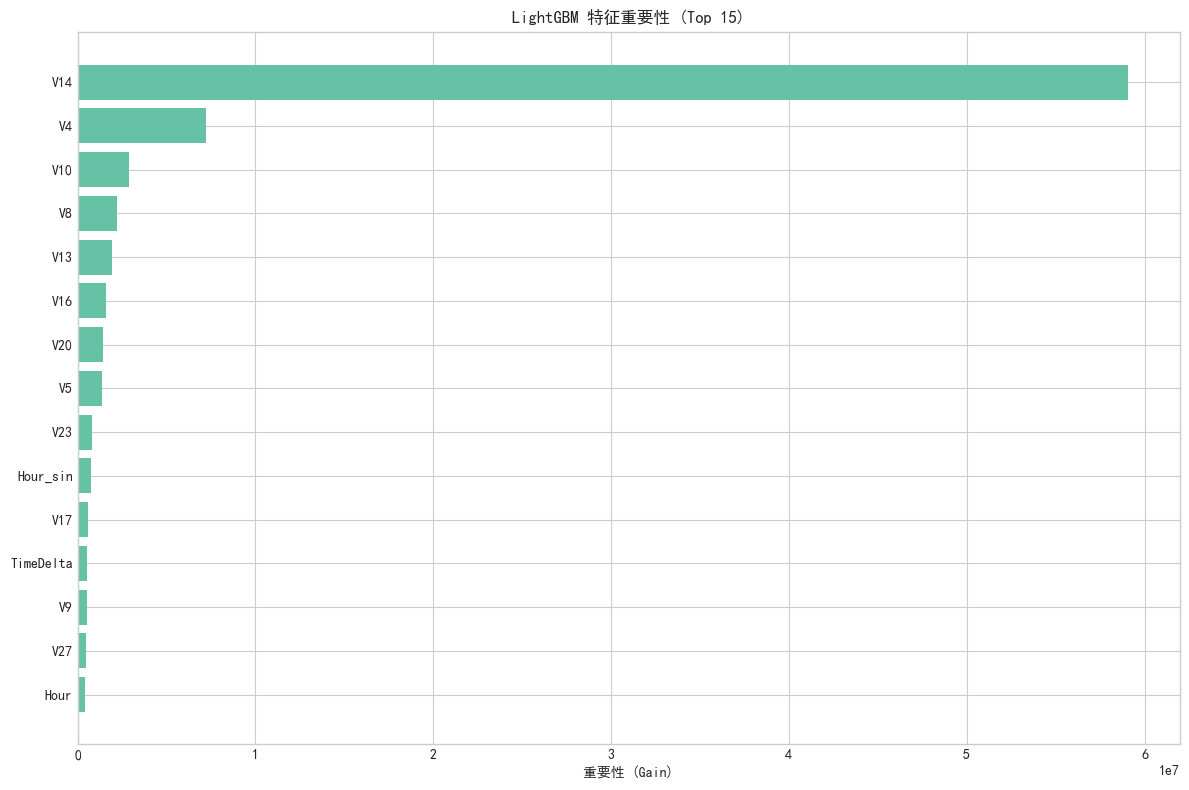

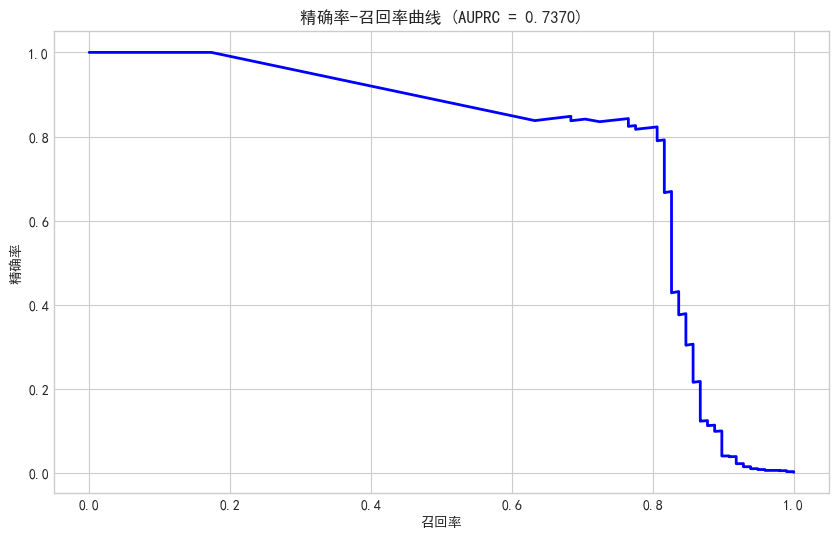

最佳模型已保存到 ../models/best_lgb_model.txt


In [37]:
# 使用最佳参数训练最终模型
print("使用最佳参数训练最终模型...")
# 如果使用dart模式，可能需要禁用早停
is_dart_mode = best_params.get('boosting_type') == 'dart'

if is_dart_mode:
    print("警告: dart模式不支持早停，将不使用早停机制")
    final_model = lgb.train(
        best_params,
        train_data,
        valid_sets=[test_data],
        num_boost_round=300
    )
else:
    final_model = lgb.train(
        best_params,
        train_data,
        valid_sets=[test_data],
        num_boost_round=300,
        callbacks=[early_stopping(stopping_rounds=50)]
    )

# 评估最终模型
final_preds = final_model.predict(X_test)
final_auprc = average_precision_score(y_test, final_preds)
print(f"最终测试集AUPRC: {final_auprc:.4f}")

# 绘制特征重要性
feature_importance = final_model.feature_importance(importance_type='gain')
feature_names = list(X_train.columns)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.title('LightGBM 特征重要性 (Top 15)')
plt.xlabel('重要性 (Gain)')
plt.gca().invert_yaxis()  # 从上到下显示
plt.tight_layout()
plt.show()

# 绘制PR曲线
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, final_preds)
avg_precision = average_precision_score(y_test, final_preds)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', linewidth=2)
plt.title(f'精确率-召回率曲线 (AUPRC = {avg_precision:.4f})')
plt.xlabel('召回率')
plt.ylabel('精确率')
plt.grid(True)
plt.show()

# 保存最佳模型
import os
os.makedirs('../models', exist_ok=True)
final_model.save_model('../models/best_lgb_model.txt')
print("最佳模型已保存到 ../models/best_lgb_model.txt")

# 6 XGBoost模型训练

In [38]:
# 导入必要的库
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
import os
import joblib

# 准备基础模型
print("\n1. 准备不同的基础模型")

# 检查训练数据中是否仍有Time特征
if 'Time' in X_train.columns:
    print("警告: Time特征仍存在，将在训练前移除")
    X_train = X_train.drop('Time', axis=1)
    X_test = X_test.drop('Time', axis=1)

# XGBoost模型
print("训练XGBoost模型...")
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=class_weight,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100,
    random_state=42
)
xgb_model.fit(X_train, y_train)


1. 准备不同的基础模型
训练XGBoost模型...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
# 评估模型
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_auprc = average_precision_score(y_test, y_pred_xgb)
print(f"  XGBoost模型 AUPRC: {xgb_auprc:.4f}")

  XGBoost模型 AUPRC: 0.7929


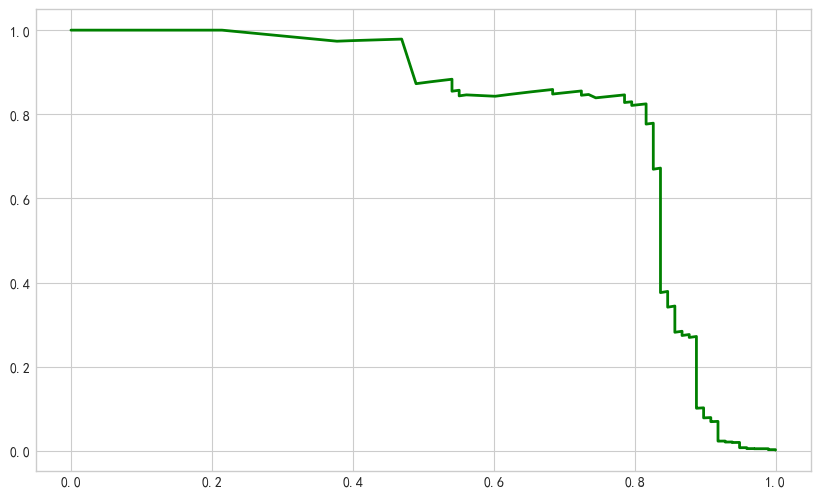

In [40]:
# 绘制XGBoost的PR曲线
plt.figure(figsize=(10, 6))
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
plt.plot(recall_xgb, precision_xgb, 'g-', linewidth=2, label=f'XGBoost (AUPRC={xgb_auprc:.4f})')

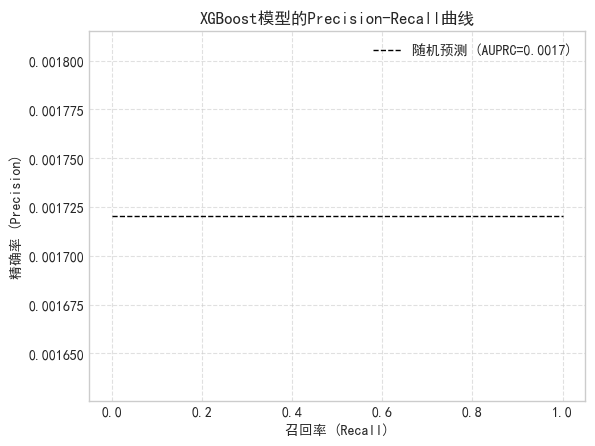

In [41]:
# 添加基线
plt.plot([0, 1], [y_test.mean(), y_test.mean()], 'k--', linewidth=1, label=f'随机预测 (AUPRC={y_test.mean():.4f})')

# 添加图形设置
plt.xlabel('召回率 (Recall)')
plt.ylabel('精确率 (Precision)')
plt.title('XGBoost模型的Precision-Recall曲线')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

In [42]:
# 保存XGBoost模型
print("保存XGBoost模型...")
os.makedirs('../outputs', exist_ok=True)
xgb_model.save_model('../outputs/xgboost_model.json')
print("XGBoost模型已保存到 '../outputs/xgboost_model.json'")

保存XGBoost模型...
XGBoost模型已保存到 '../outputs/xgboost_model.json'


In [43]:
# 保存模型预测结果
joblib.dump(y_pred_xgb, '../outputs/xgb_predictions.pkl')
print("XGBoost预测结果已保存")

XGBoost预测结果已保存


In [44]:
# 打印总结
print("\nXGBoost模型性能:")
print(f"AUPRC: {xgb_auprc:.4f}")


XGBoost模型性能:
AUPRC: 0.7929
